In [54]:
# pip install icrawler
# pip install --upgrade lxml
# !pip install facenet-pytorch
# !pip install torch torchvision
# !pip install torchvision

In [ ]:
import os
import requests
import hashlib
from bs4 import BeautifulSoup
from urllib.parse import quote_plus
from PIL import Image
from io import BytesIO
import time
import json

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from itertools import cycle

from facenet_pytorch import MTCNN
from tqdm import tqdm
import torch

import shutil
import random

from facenet_pytorch import InceptionResnetV1
from torchvision import transforms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.optim as optim

# DATA COLLECTION

In [1]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36'}

celebrities = ['kendall jenner', 'cristiano ronaldo', 'jacob elordi', 'jennie', 'cha eun woo', 
               'robert pattinson', 'bella hadid', 'zendaya', 'rihanna', 'will smith']

output_root = "dataset_raw"
os.makedirs(output_root, exist_ok=True)

def is_good_image(image_bytes):
    try:
        image = Image.open(BytesIO(image_bytes))
        return image.size[0] >= 200 and image.size[1] >= 200
    except:
        return False

for name in celebrities:
    folder = os.path.join(output_root, name.replace(" ", "_"))
    os.makedirs(folder, exist_ok=True)

    print(f"Starting: {name}")
    
    seen_hashes = set()
    count = 0
    start = 0

    while count < 200 and start < 1000:
        search_url = f"https://www.bing.com/images/async?q={quote_plus(name + ' face')}&first={start}&count=35&relp=35"
        try:
            res = requests.get(search_url, headers=headers)
            soup = BeautifulSoup(res.text, "html.parser")

            scripts = soup.find_all("a", class_="iusc")
            for tag in scripts:
                try:
                    metadata = json.loads(tag["m"])
                    img_url = metadata["murl"]
                    img_data = requests.get(img_url, headers=headers, timeout=5).content

                    img_hash = hashlib.md5(img_data).hexdigest()
                    if img_hash in seen_hashes:
                        continue
                    if not is_good_image(img_data):
                        continue

                    seen_hashes.add(img_hash)
                    with open(os.path.join(folder, f"{count}.jpg"), "wb") as f:
                        f.write(img_data)
                    count += 1

                    time.sleep(0.1)
                except Exception:
                    continue
        except Exception as e:
            print(f"Error: {e}")
            
        start += 35

# SIMPLE MODELS WITH NO PREPROCESSING

## split to train and test datasets

In [150]:
data_dir = "dataset_raw"
image_size = (64, 64)

X = []
y = []
image_paths = []

for celeb in os.listdir(data_dir):
    celeb_path = os.path.join(data_dir, celeb)
    if not os.path.isdir(celeb_path):
        continue
    for img_name in os.listdir(celeb_path):
        img_path = os.path.join(celeb_path, img_name)
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            try:
                img = Image.open(img_path).convert("RGB").resize(image_size)
                img_array = np.asarray(img).flatten()
                X.append(img_array)
                y.append(celeb)
                image_paths.append(img_path)
            except:
                continue

X = np.array(X)
y = np.array(y)
image_paths = np.array(image_paths)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test, train_paths, test_paths = train_test_split(X, y_encoded, image_paths, test_size=0.2, 
                                                                             random_state=42, stratify=y_encoded)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [135]:
def print_output_of_model(y_test, y_pred, model_name):
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"Confusion Matrix - Raw Pixel Input - {model_name}")
    plt.tight_layout()
    plt.show()


    y_test_bin = label_binarize(y_test, classes=list(range(len(le.classes_))))
    n_classes = y_test_bin.shape[1]
    y_score = rf.predict_proba(X_test)
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["macro"], tpr["macro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'pink', 'olive', 'teal', 'brown'])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.2f})', color='navy', linestyle=':', linewidth=4)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'{le.classes_[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve per Class ({model_name} on Raw Pixels)')
    plt.legend(loc="lower right", fontsize=8)
    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_prediction_grid(title, y_pred_labels, y_true_labels, image_paths, grid_size=5, figsize=(8, 8)):
    n = grid_size ** 2
    indices = list(range(len(image_paths)))
    random.shuffle(indices)

    fig, axes = plt.subplots(grid_size, grid_size, figsize=figsize)
    fig.suptitle(title, fontsize=14)

    for i, ax in enumerate(axes.flat):
        if i >= len(indices): break
        idx = indices[i]
        img = Image.open(image_paths[idx]).resize((64, 64))
        ax.imshow(img)
        pred = y_pred_labels[idx]
        true = y_true_labels[idx]
        color = 'black' if pred == true else 'red'
        ax.set_title(pred, fontsize=9, color=color)
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

## models

                   precision    recall  f1-score   support

      bella_hadid       0.32      0.42      0.36        43
      cha_eun_woo       0.59      0.59      0.59        46
cristiano_ronaldo       0.47      0.42      0.45        45
     jacob_elordi       0.38      0.29      0.32        42
           jennie       0.41      0.40      0.41        42
   kendall_jenner       0.42      0.51      0.46        41
          rihanna       0.50      0.37      0.43        43
 robert_pattinson       0.39      0.40      0.40        45
       will_smith       0.53      0.53      0.53        43
          zendaya       0.39      0.42      0.40        43

         accuracy                           0.44       433
        macro avg       0.44      0.44      0.44       433
     weighted avg       0.44      0.44      0.44       433



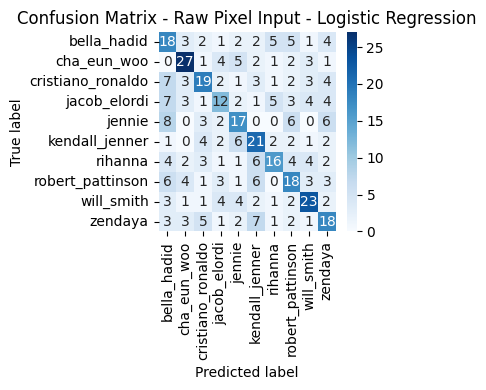

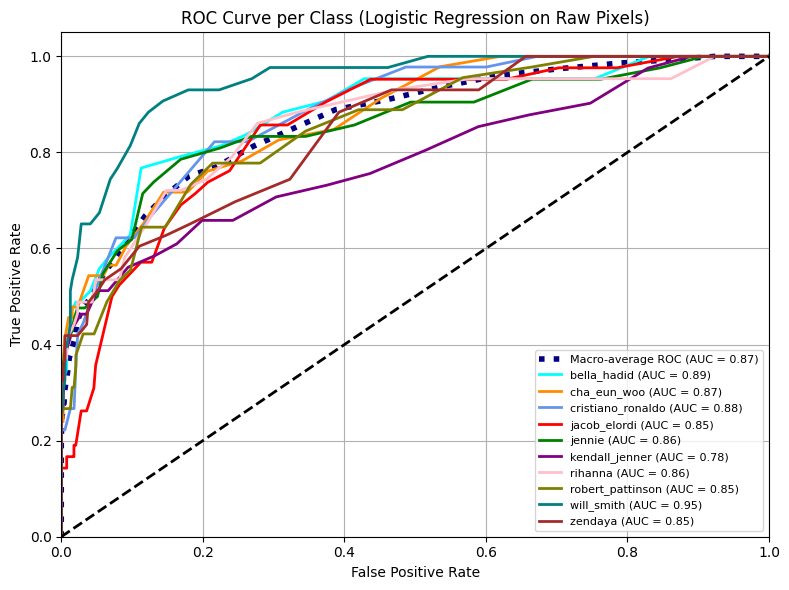

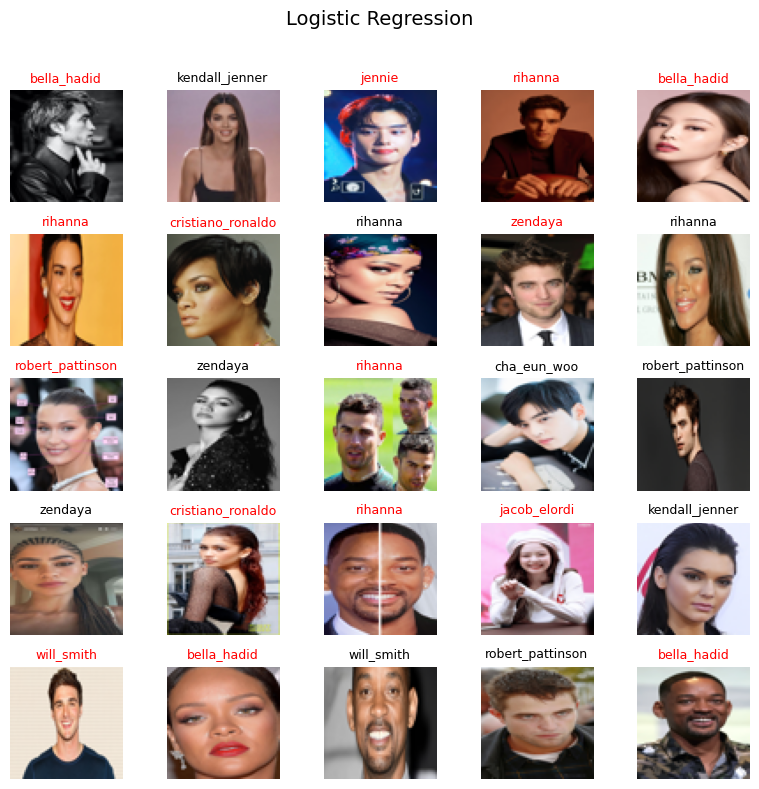

                   precision    recall  f1-score   support

      bella_hadid       0.46      0.58      0.52        43
      cha_eun_woo       0.58      0.65      0.61        46
cristiano_ronaldo       0.43      0.44      0.44        45
     jacob_elordi       0.37      0.38      0.38        42
           jennie       0.48      0.50      0.49        42
   kendall_jenner       0.45      0.46      0.46        41
          rihanna       0.50      0.37      0.43        43
 robert_pattinson       0.51      0.44      0.48        45
       will_smith       0.61      0.53      0.57        43
          zendaya       0.40      0.40      0.40        43

         accuracy                           0.48       433
        macro avg       0.48      0.48      0.48       433
     weighted avg       0.48      0.48      0.48       433



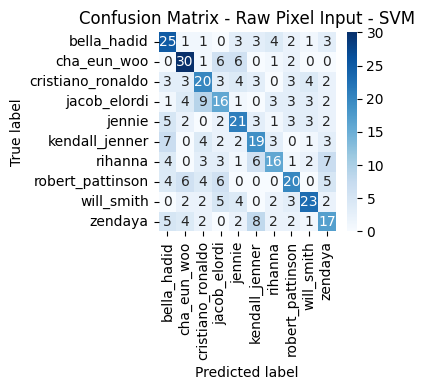

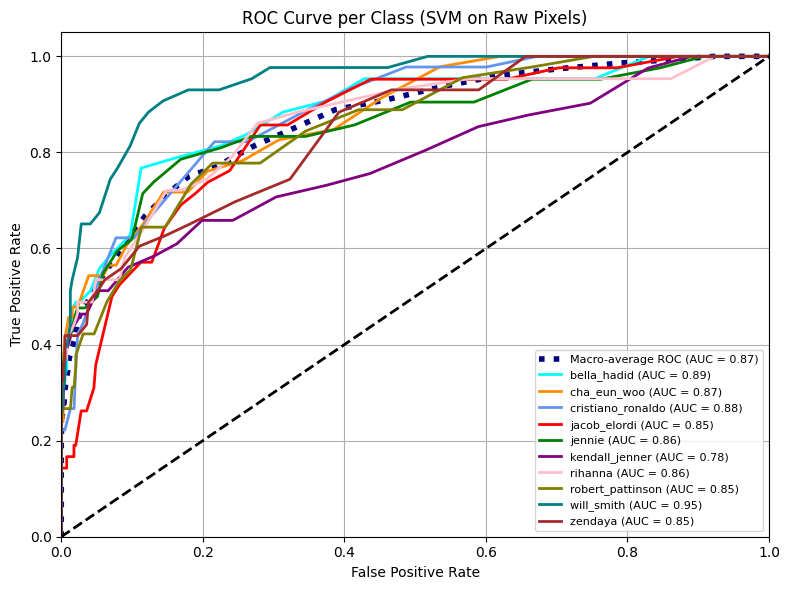

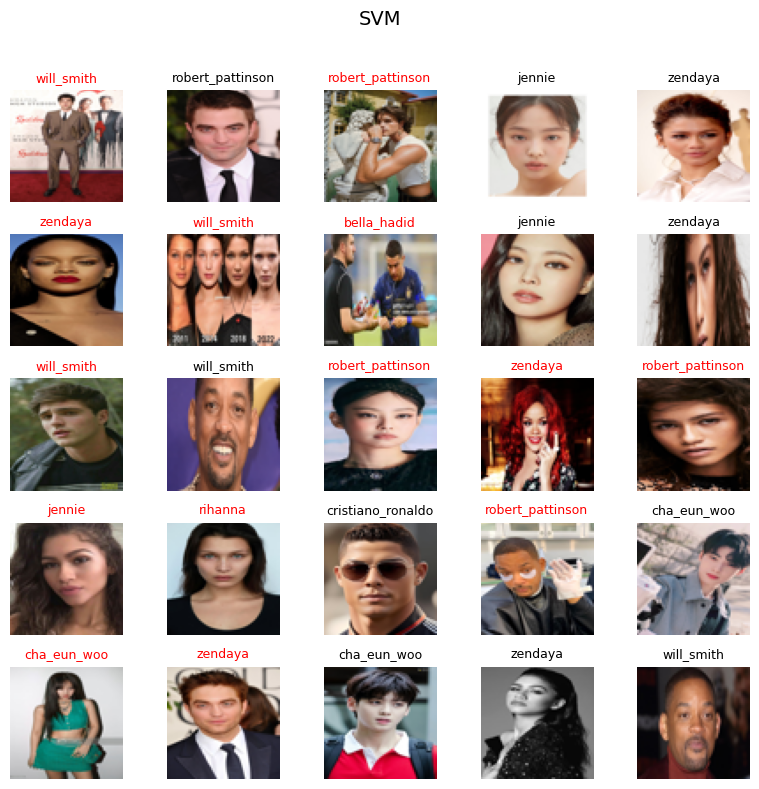

                   precision    recall  f1-score   support

      bella_hadid       0.27      0.58      0.37        43
      cha_eun_woo       0.36      0.33      0.34        46
cristiano_ronaldo       0.30      0.47      0.37        45
     jacob_elordi       0.26      0.29      0.27        42
           jennie       0.24      0.21      0.23        42
   kendall_jenner       0.36      0.24      0.29        41
          rihanna       0.47      0.16      0.24        43
 robert_pattinson       0.44      0.18      0.25        45
       will_smith       0.37      0.49      0.42        43
          zendaya       0.46      0.28      0.35        43

         accuracy                           0.32       433
        macro avg       0.35      0.32      0.31       433
     weighted avg       0.35      0.32      0.31       433



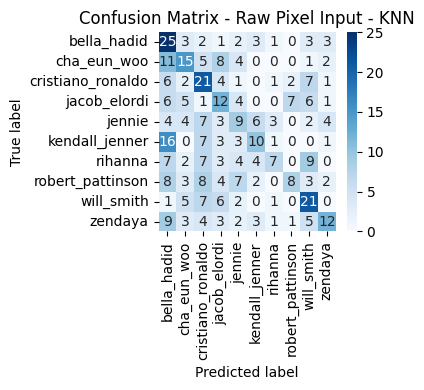

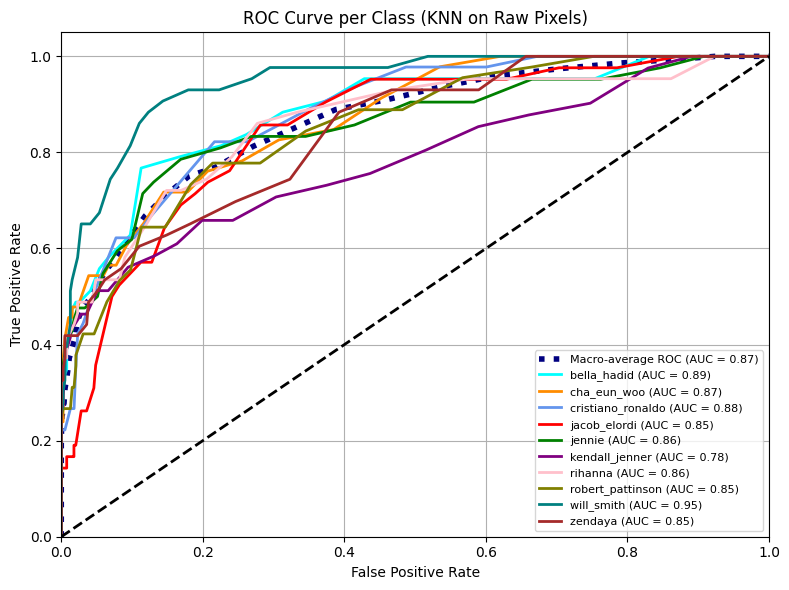

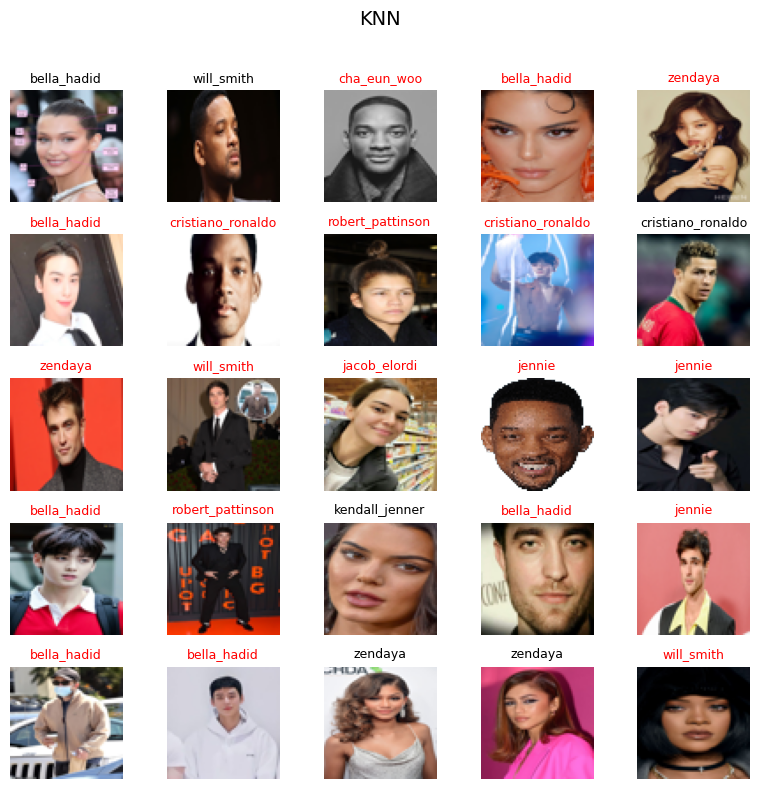

                   precision    recall  f1-score   support

      bella_hadid       0.57      0.53      0.55        43
      cha_eun_woo       0.55      0.52      0.53        46
cristiano_ronaldo       0.49      0.44      0.47        45
     jacob_elordi       0.36      0.48      0.41        42
           jennie       0.50      0.48      0.49        42
   kendall_jenner       0.53      0.46      0.49        41
          rihanna       0.50      0.51      0.51        43
 robert_pattinson       0.55      0.53      0.54        45
       will_smith       0.60      0.74      0.67        43
          zendaya       0.58      0.49      0.53        43

         accuracy                           0.52       433
        macro avg       0.52      0.52      0.52       433
     weighted avg       0.52      0.52      0.52       433



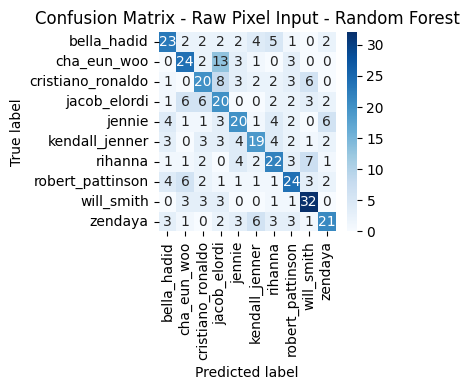

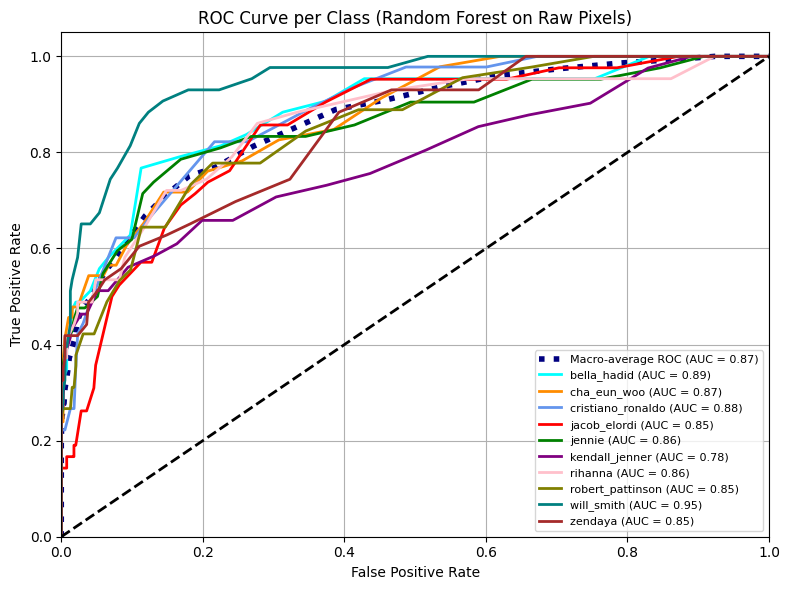

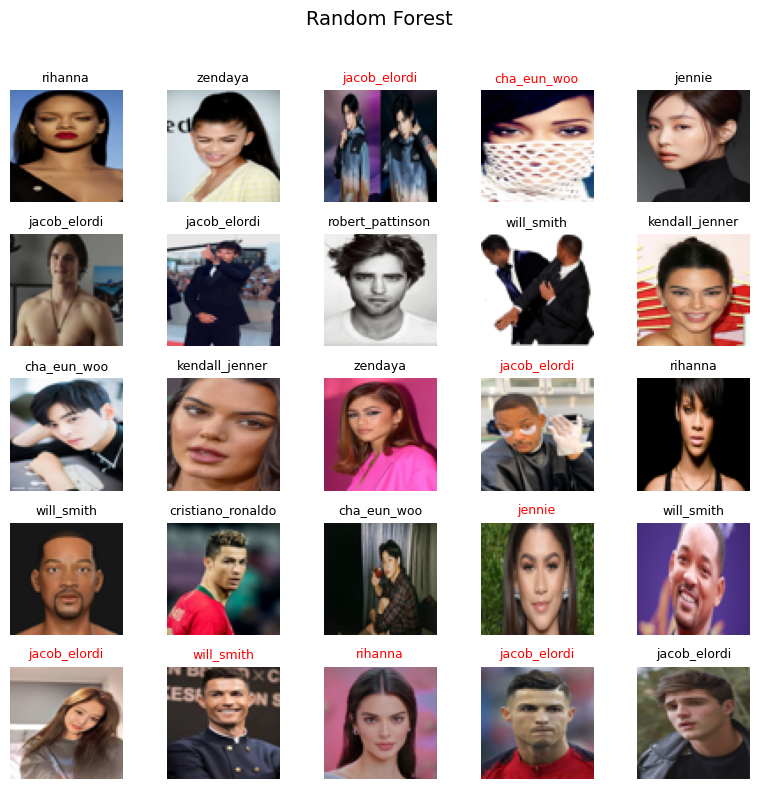

                   precision    recall  f1-score   support

      bella_hadid       0.40      0.09      0.15        43
      cha_eun_woo       0.25      0.41      0.31        46
cristiano_ronaldo       0.17      0.02      0.04        45
     jacob_elordi       0.14      0.12      0.13        42
           jennie       0.29      0.29      0.29        42
   kendall_jenner       0.15      0.12      0.14        41
          rihanna       0.22      0.23      0.23        43
 robert_pattinson       0.19      0.53      0.28        45
       will_smith       0.33      0.12      0.17        43
          zendaya       0.32      0.33      0.32        43

         accuracy                           0.23       433
        macro avg       0.25      0.23      0.21       433
     weighted avg       0.25      0.23      0.21       433



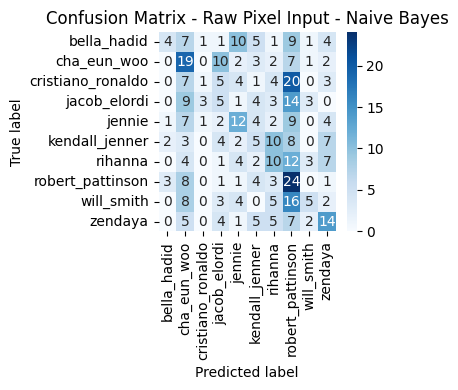

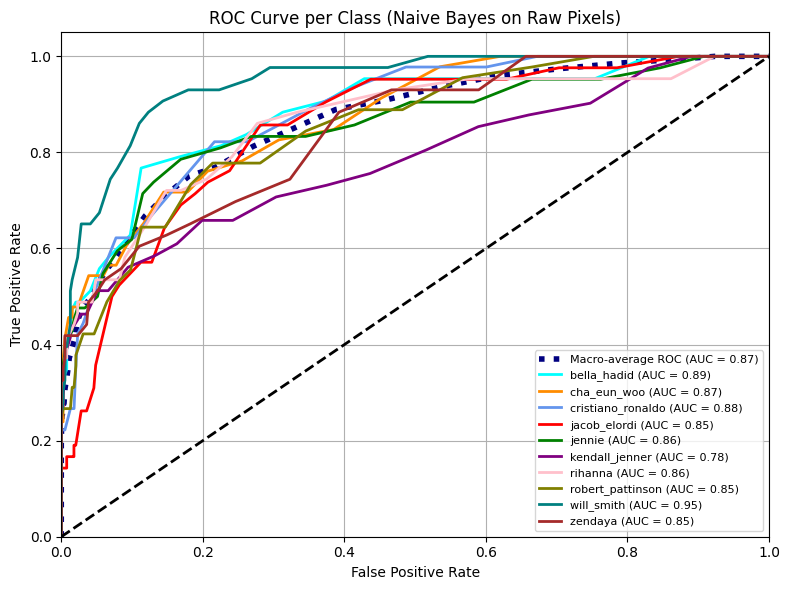

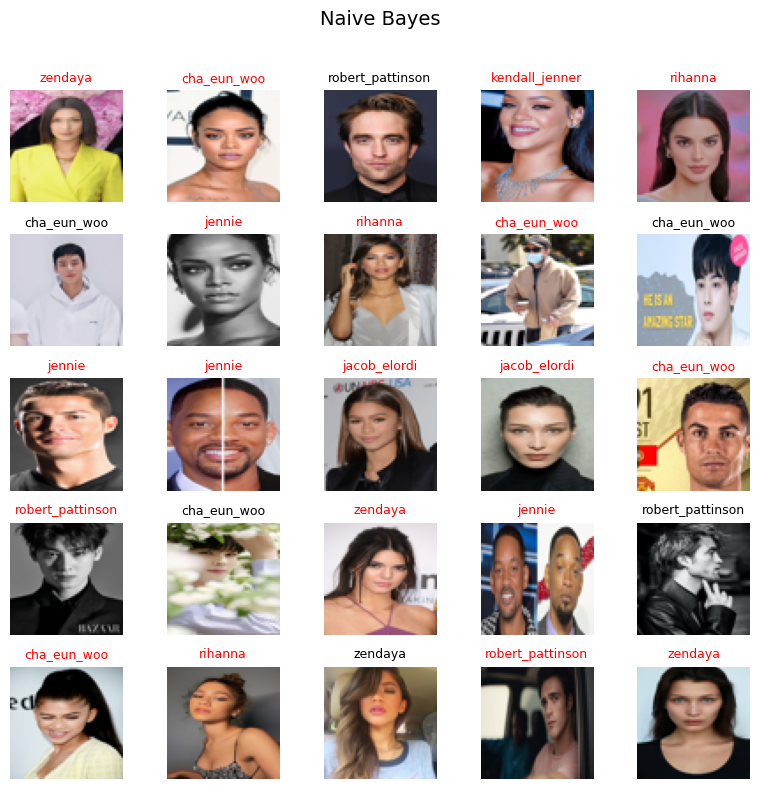

In [151]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(kernel='linear', probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=3), 
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': GaussianNB()
}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print_output_of_model(y_test, y_pred, name)

    plot_prediction_grid(name, le.inverse_transform(y_pred), le.inverse_transform(y_test), test_paths)

# SIMPLE MODELS WITH MTCNN

## preprocessing

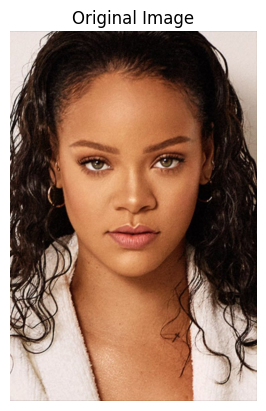

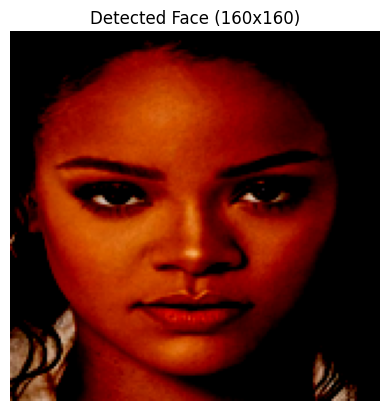

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
mtcnn = MTCNN(image_size=160, margin=20, post_process=True, device=device)

# Pick one image
img_path = "dataset_raw/rihanna/0.jpg"
img = Image.open(img_path).convert("RGB")

# Show original
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")
plt.show()

# Detect face
face_tensor = mtcnn(img)

# Show result
if face_tensor is not None:
    face_img = Image.fromarray((face_tensor.permute(1, 2, 0).clamp(0, 1).cpu().numpy() * 255).astype('uint8'))
    plt.imshow(face_img)
    plt.title("Detected Face (160x160)")
    plt.axis("off")
    plt.show()
else:
    print("No face detected.")

In [40]:
input_root = "dataset_raw"
output_root = "dataset_aligned/train"
os.makedirs(output_root, exist_ok=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
mtcnn = MTCNN(image_size=160, margin=20, post_process=True, device=device)

for person in os.listdir(input_root):
    person_in = os.path.join(input_root, person)
    person_out = os.path.join(output_root, person)
    os.makedirs(person_out, exist_ok=True)

    for img_name in tqdm(os.listdir(person_in), desc=f"Cropping {person}"):
        try:
            img_path = os.path.join(person_in, img_name)
            img = Image.open(img_path).convert("RGB")

            face_tensor = mtcnn(img)
            if face_tensor is None:
                continue

            face_img = Image.fromarray(
                (face_tensor.permute(1, 2, 0).clamp(0, 1).cpu().numpy() * 255).astype('uint8')
            )
            face_img.save(os.path.join(person_out, img_name))
        except Exception:
            continue

Cropping cristiano_ronaldo:  40%|████████████████████████████████▍                                                 | 89/225 [00:15<00:30,  4.47it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Cropping will_smith: 100%|████████████████████████████████████████████████████████████████████████████████████████| 216/216 [01:14<00:00,  2.88it/s]


## split to train and test datasets

In [41]:
input_dir = "dataset_aligned/train"
output_dir = "dataset_aligned"
test_ratio = 0.2

for person in os.listdir(input_dir):
    person_dir = os.path.join(input_dir, person)
    test_dir = os.path.join(output_dir, "test", person)
    os.makedirs(test_dir, exist_ok=True)

    images = os.listdir(person_dir)
    random.shuffle(images)

    test_count = int(len(images) * test_ratio)
    test_images = images[:test_count]

    for img in test_images:
        src = os.path.join(person_dir, img)
        dst = os.path.join(test_dir, img)
        shutil.move(src, dst) 

In [44]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])])

def load_data(folder):
    X, y = [], []
    for person in os.listdir(folder):
        person_dir = os.path.join(folder, person)
        for img_name in os.listdir(person_dir):
            img_path = os.path.join(person_dir, img_name)
            try:
                img = Image.open(img_path).convert("RGB")
                img_tensor = transform(img).unsqueeze(0).to(device)
                with torch.no_grad():
                    embedding = resnet(img_tensor).cpu().numpy().flatten()
                X.append(embedding)
                y.append(person)
            except:
                continue
    return np.array(X), np.array(y)

X_train, y_train = load_data("dataset_aligned/train")
X_test, y_test = load_data("dataset_aligned/test")

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(kernel='linear', probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=3), 
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': GaussianNB()
}

for name, model in models.items():
    model.fit(X_train, y_train_enc)
    y_pred = model.predict(X_test)
    print(f"\n{name}:\n", classification_report(y_test_enc, y_pred, target_names=le.classes_))



Logistic Regression:
                    precision    recall  f1-score   support

      bella_hadid       1.00      1.00      1.00        42
      cha_eun_woo       0.96      0.98      0.97        45
cristiano_ronaldo       0.98      0.98      0.98        44
     jacob_elordi       0.93      0.98      0.95        41
           jennie       1.00      0.95      0.97        41
   kendall_jenner       1.00      1.00      1.00        40
          rihanna       1.00      1.00      1.00        42
 robert_pattinson       0.98      0.93      0.95        44
       will_smith       1.00      1.00      1.00        42
          zendaya       0.98      1.00      0.99        41

         accuracy                           0.98       422
        macro avg       0.98      0.98      0.98       422
     weighted avg       0.98      0.98      0.98       422


SVM:
                    precision    recall  f1-score   support

      bella_hadid       1.00      1.00      1.00        42
      cha_eun_woo     

# CNN

In [48]:
train_dir = "dataset_aligned/train"
test_dir = "dataset_aligned/test"

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

class_names = train_data.classes
num_classes = len(class_names)

In [95]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

model_cnn = SimpleCNN(num_classes).to(device)

In [96]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 10
for epoch in range(epochs):
    model_cnn.train()
    running_loss = 0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:17<00:00,  3.08it/s]


Epoch 1/10, Loss: 124.3703


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:17<00:00,  3.15it/s]


Epoch 2/10, Loss: 124.3860


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:17<00:00,  3.14it/s]


Epoch 3/10, Loss: 124.3860


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:17<00:00,  3.09it/s]


Epoch 4/10, Loss: 124.3725


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:17<00:00,  3.16it/s]


Epoch 5/10, Loss: 124.3617


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:16<00:00,  3.20it/s]


Epoch 6/10, Loss: 124.3926


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:17<00:00,  3.14it/s]


Epoch 7/10, Loss: 124.3816


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:17<00:00,  3.18it/s]


Epoch 8/10, Loss: 124.3693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:16<00:00,  3.18it/s]


Epoch 9/10, Loss: 124.3809


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:17<00:00,  3.16it/s]

Epoch 10/10, Loss: 124.3842


In [51]:
model_cnn.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model_cnn(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds, target_names=class_names))

                   precision    recall  f1-score   support

      bella_hadid       0.70      0.76      0.73        42
      cha_eun_woo       0.72      0.87      0.79        45
cristiano_ronaldo       0.72      0.77      0.75        44
     jacob_elordi       0.81      0.63      0.71        41
           jennie       0.82      0.80      0.81        41
   kendall_jenner       0.84      0.53      0.65        40
          rihanna       0.79      0.71      0.75        42
 robert_pattinson       0.73      0.61      0.67        44
       will_smith       0.76      0.98      0.85        42
          zendaya       0.67      0.80      0.73        41

         accuracy                           0.75       422
        macro avg       0.76      0.75      0.74       422
     weighted avg       0.76      0.75      0.74       422



# RESNET

In [57]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

num_classes = len(train_data.classes)

model_rn = models.resnet50(pretrained=True)
model_rn.fc = nn.Linear(model_rn.fc.in_features, num_classes)
model_rn = model_rn.to(device)

for name, param in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_rn.fc.parameters(), lr=1e-4)

epochs = 10
for epoch in range(epochs):
    model_rn.train()
    running_loss = 0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_rn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [03:29<00:00,  3.88s/it]


Epoch 1/10, Loss: 122.4166


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [03:28<00:00,  3.86s/it]


Epoch 2/10, Loss: 111.7730


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [03:28<00:00,  3.86s/it]


Epoch 3/10, Loss: 103.0103


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [03:25<00:00,  3.80s/it]


Epoch 4/10, Loss: 96.4764


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [03:31<00:00,  3.91s/it]


Epoch 5/10, Loss: 90.0271


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [03:30<00:00,  3.90s/it]


Epoch 6/10, Loss: 85.6143


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [03:28<00:00,  3.86s/it]


Epoch 7/10, Loss: 81.3347


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [03:25<00:00,  3.81s/it]


Epoch 8/10, Loss: 77.9982


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [03:29<00:00,  3.89s/it]


Epoch 9/10, Loss: 74.4814


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [03:28<00:00,  3.87s/it]

Epoch 10/10, Loss: 71.8454


In [58]:
model_rn.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model_rn(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds, target_names=train_data.classes))

                   precision    recall  f1-score   support

      bella_hadid       0.68      0.71      0.70        42
      cha_eun_woo       0.57      0.64      0.60        45
cristiano_ronaldo       0.81      0.77      0.79        44
     jacob_elordi       0.58      0.61      0.60        41
           jennie       0.81      0.71      0.75        41
   kendall_jenner       0.64      0.57      0.61        40
          rihanna       0.78      0.60      0.68        42
 robert_pattinson       0.74      0.57      0.64        44
       will_smith       0.74      0.88      0.80        42
          zendaya       0.54      0.71      0.61        41

         accuracy                           0.68       422
        macro avg       0.69      0.68      0.68       422
     weighted avg       0.69      0.68      0.68       422



# RESULTS

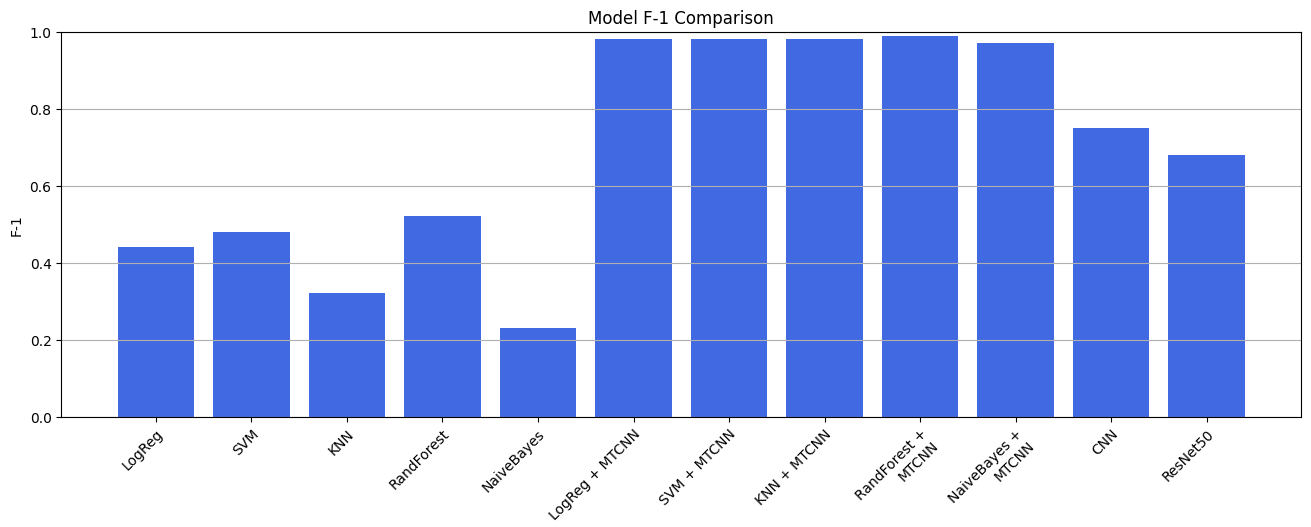

In [147]:
results = {
    'LogReg': 0.44,
    'SVM': 0.48,
    'KNN': 0.32,
    'RandForest': 0.52,
    'NaiveBayes': 0.23,
    
    'LogReg + MTCNN': 0.98,
    'SVM + MTCNN': 0.98,
    'KNN + MTCNN': 0.98,
    'RandForest + MTCNN': 0.99,
    'NaiveBayes + MTCNN': 0.97,
    'CNN': 0.75,
    'ResNet50': 0.68
}

plt.figure(figsize=(16, 5))
plt.bar(results.keys(), results.values(), color='royalblue')
plt.xticks(rotation=45, ha='right', wrap=True)
plt.ylabel("F-1")
plt.title("Model F-1 Comparison")
plt.ylim(0.0, 1.0)
plt.grid(axis='y')
plt.show()


# CHECK (BACKUP)

Label index: 3
Label name: jacob_elordi
Image file: dataset_aligned/test/jacob_elordi/45.jpg


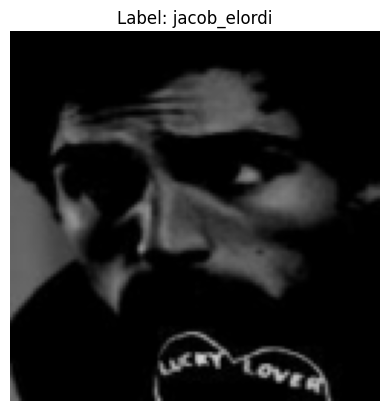

In [81]:
from PIL import Image
import matplotlib.pyplot as plt

index_check = 160
# Check sample 0 from train_data
# image_tensor, label_idx = train_data[index_check]
# label_name = train_data.classes[label_idx]
# image_path, _ = train_data.samples[index_check]

image_tensor, label_idx = test_data[index_check]
label_name = test_data.classes[label_idx]
image_path, _ = test_data.samples[index_check]

print(f"Label index: {label_idx}")
print(f"Label name: {label_name}")
print(f"Image file: {image_path}")

# Convert tensor back to image for display
unnorm = transforms.Normalize(mean=[-1], std=[2])  # Reverse Normalize [0,1]
img_display = unnorm(image_tensor).permute(1, 2, 0).numpy().clip(0, 1)

plt.imshow(img_display)
plt.title(f"Label: {label_name}")
plt.axis('off')
plt.show()


In [87]:
train_dir = "dataset_aligned/train"
test_dir = "dataset_aligned/test"
data = []
celebrities = sorted(os.listdir(train_dir))

for celeb in celebrities:
    train_path = os.path.join(train_dir, celeb)
    test_path = os.path.join(test_dir, celeb)
    train_count = len([f for f in os.listdir(train_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    test_count = len([f for f in os.listdir(test_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

    data.append({
        'Celebrity': celeb,
        'Train Images': train_count,
        'Test Images': test_count
    })

df = pd.DataFrame(data)

In [88]:
df

Celebrity  Train Images  Test Images
0        bella_hadid           171           42
1        cha_eun_woo           180           45
2  cristiano_ronaldo           180           44
3       jacob_elordi           165           41
4             jennie           168           41
5     kendall_jenner           164           40
6            rihanna           172           42
7   robert_pattinson           179           44
8         will_smith           172           42
9            zendaya           167           41

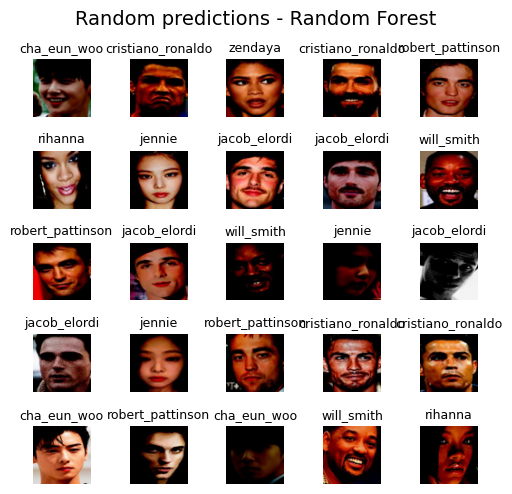

In [112]:
logreg_model = LogisticRegression(max_iter=1000).fit(X_train, y_train_enc)
svm_model = SVC(kernel='linear', probability=True).fit(X_train, y_train_enc)
knn_model = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train_enc)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train_enc)
nb_model = GaussianNB().fit(X_train, y_train_enc)


y_pred_rf = le.inverse_transform(rf_model.predict(X_test)) 
y_pred_svm = le.inverse_transform(svm_model.predict(X_test)) 
y_pred_lr = le.inverse_transform(logreg_model.predict(X_test)) 
y_pred_knn = le.inverse_transform(knn_model.predict(X_test)) 
y_pred_nb = le.inverse_transform(nb_model.predict(X_test)) 
# y_pred_cnn = le.inverse_transform(model_cnn.predict(X_test)) 
# y_pred_rn = le.inverse_transform(model_rn.predict(X_test))

title = 'Random predictions - Random Forest'
y_pred_labels = y_pred_rf
y_true_labels = le.inverse_transform(y_test_enc)
image_paths = X_test_paths
plot_prediction_grid(title, y_pred_labels, y_true_labels, image_paths, grid_size=5, figsize=(5, 5))

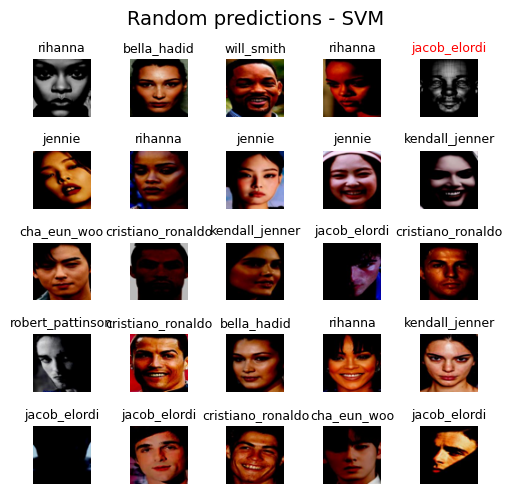

In [113]:
title = 'Random predictions - SVM'
y_pred_labels = y_pred_svm
y_true_labels = le.inverse_transform(y_test_enc)
image_paths = X_test_paths
plot_prediction_grid(title, y_pred_labels, y_true_labels, image_paths, grid_size=5, figsize=(5, 5))

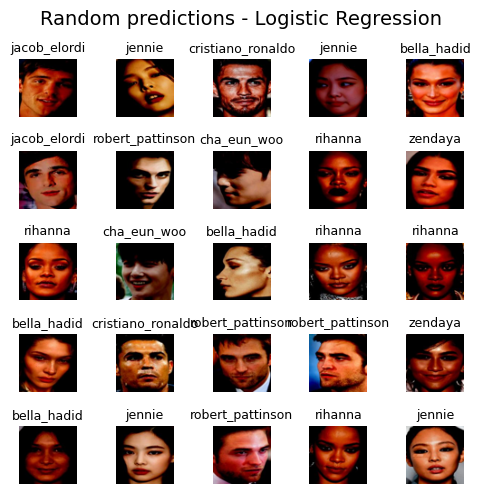

In [114]:
title = 'Random predictions - Logistic Regression'
y_pred_labels = y_pred_lr
y_true_labels = le.inverse_transform(y_test_enc)
image_paths = X_test_paths
plot_prediction_grid(title, y_pred_labels, y_true_labels, image_paths, grid_size=5, figsize=(5, 5))

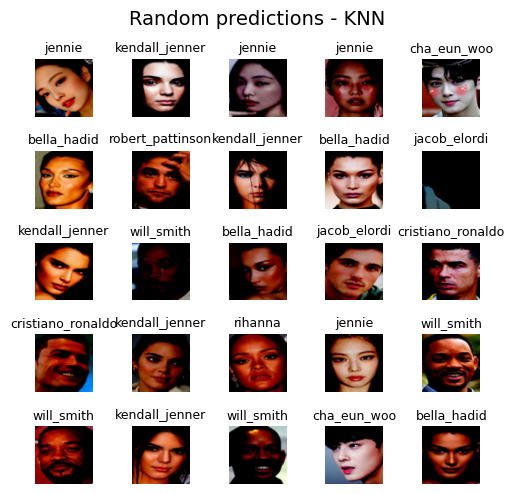

In [115]:
title = 'Random predictions - KNN'
y_pred_labels = y_pred_knn
y_true_labels = le.inverse_transform(y_test_enc)
image_paths = X_test_paths
plot_prediction_grid(title, y_pred_labels, y_true_labels, image_paths, grid_size=5, figsize=(5, 5))

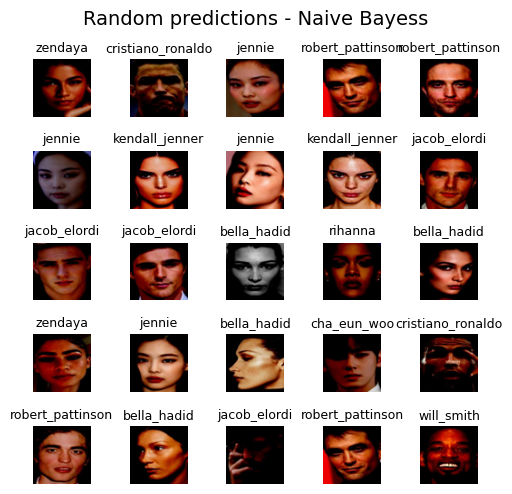

In [116]:
title = 'Random predictions - Naive Bayess'
y_pred_labels = y_pred_nb
y_true_labels = le.inverse_transform(y_test_enc)
image_paths = X_test_paths
plot_prediction_grid(title, y_pred_labels, y_true_labels, image_paths, grid_size=5, figsize=(5, 5))

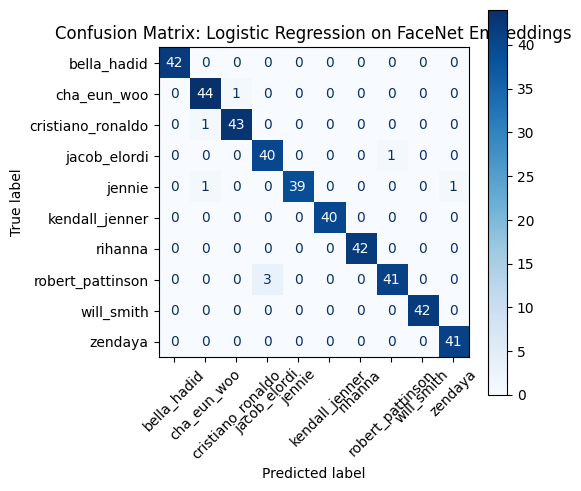

In [120]:
cm = confusion_matrix(y_test_enc, le.transform(y_pred_lr))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix: Logistic Regression on FaceNet Embeddings")
plt.show()

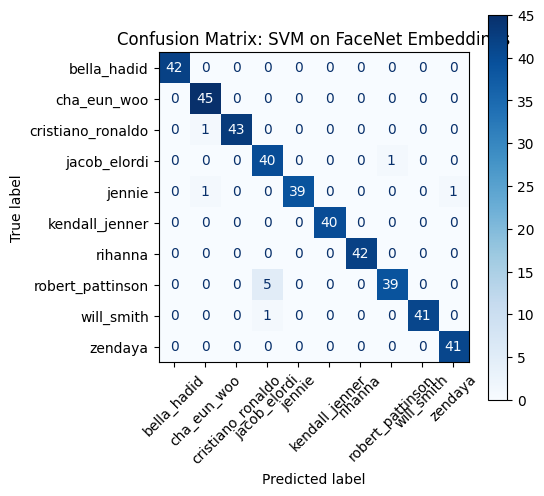

In [121]:
cm = confusion_matrix(y_test_enc, le.transform(y_pred_svm))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix: SVM on FaceNet Embeddings")
plt.show()

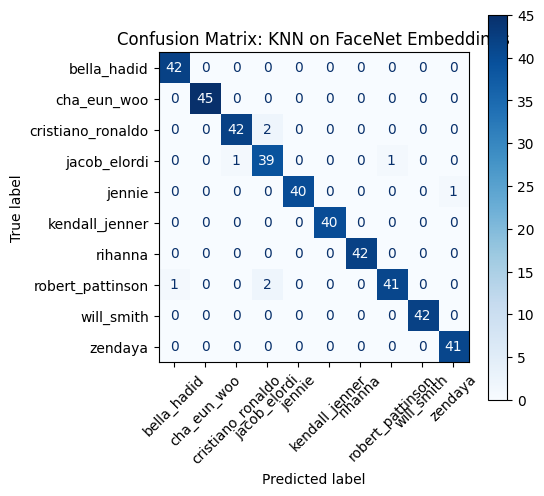

In [122]:
cm = confusion_matrix(y_test_enc, le.transform(y_pred_knn))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix: KNN on FaceNet Embeddings")
plt.show()

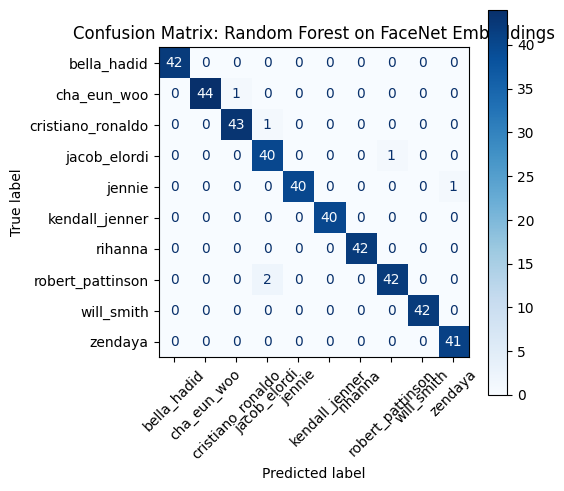

In [123]:
cm = confusion_matrix(y_test_enc, le.transform(y_pred_rf))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix: Random Forest on FaceNet Embeddings")
plt.show()

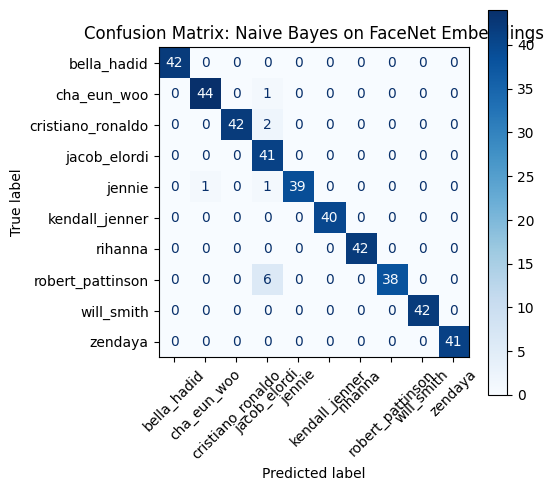

In [129]:
cm = confusion_matrix(y_test_enc, le.transform(y_pred_nb))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix: Naive Bayes on FaceNet Embeddings")
plt.show()